In [2]:
# Option Pricing Using Fast Fourier Transform (FFT)

''' This notebook implements methods for pricing European call options using various approaches,
including Monte Carlo simulations, Fourier Transform methods, and the Fast Fourier Transform.
 '''


### 1. Imports and Setup

import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy.integrate import quad
from scipy.stats import norm, gamma




In [3]:


### 2. Functions for Stochastic Processes
#### Geometric Brownian Motion

def gbm_phi(S0, r, sigma, t, u):
    mu = np.log(S0) + (r - 0.5 * sigma**2) * t
    var = t * sigma**2
    return np.exp(1j * u * mu - 0.5 * u**2 * var)

def gbm_sample_path(S0, r, sigma, T, N=200, plot=False):
    dt = T / N
    t = np.linspace(0, T, N + 1)
    dW = np.random.normal(0, np.sqrt(dt), N)
    W = np.insert(np.cumsum(dW), 0, 0)

    S_sim = S0 * np.exp((r - 0.5 * sigma**2) * t + sigma * W)
    if plot:
        plt.plot(t, S_sim)
        plt.title("Geometric Brownian Motion Sample Path")
        plt.show()
    return S_sim[-1]

#### Variance Gamma

def vg_phi(S0, r, sigma, theta, nu, t, u):
    omega = (1 / nu) * np.log(1 - theta * nu - 0.5 * nu * sigma**2)
    denom = (1 - 1j * theta * nu * u + 0.5 * (u * sigma)**2 * nu)**(t / nu)
    return np.exp(1j * u * (np.log(S0) + (r + omega) * t)) / denom

def vg_sample_path(S0, r, sigma, theta, nu, T, N=200, plot=False):
    dt = T / N
    t = np.linspace(0, T, N + 1)
    dG = np.random.gamma(dt / nu, nu, N)
    Z = np.random.normal(0, 1, N)

    X = theta * np.cumsum(dG) + sigma * np.cumsum(np.sqrt(dG) * Z)
    X = np.insert(X, 0, 0)
    omega = (1 / nu) * np.log(1 - theta * nu - 0.5 * nu * sigma**2)
    S_sim = S0 * np.exp((r + omega) * t + X)

    if plot:
        plt.plot(t, S_sim)
        plt.title("Variance Gamma Process Sample Path")
        plt.show()
    return S_sim[-1]




### 3. European Call Option Pricing
#### Payoff Function

def call_payoff(ST, K):
    return max(ST - K, 0)

#### Monte Carlo Simulation

def monte_carlo_price(S0, r, sigma, T, K, n=1000, process="gbm", theta=None, nu=None):
    payoffs = []
    for _ in range(n):
        if process == "gbm":
            ST = gbm_sample_path(S0, r, sigma, T)
        elif process == "vg":
            ST = vg_sample_path(S0, r, sigma, theta, nu, T)
        else:
            raise ValueError("Invalid process type")

        payoffs.append(call_payoff(ST, K))
    return np.exp(-r * T) * np.mean(payoffs)


#### Black-Scholes Formula

def black_scholes_price(S0, r, sigma, T, K):
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    delta = norm.cdf(d1)
    PrITM = norm.cdf(d2)

    return S0 * delta - K * np.exp(-r * T) * PrITM



### 4. Fourier Transform Methods
#### Log Strike Partition

def log_strike_partition(eta=0.25, N=4096):
    b = np.pi / eta
    lamb = 2 * np.pi / (eta * N)
    k = -b + lamb * np.arange(N)
    return b, lamb, k


#### FFT Pricing

def fft_price(S0, r, sigma, T, alpha=1.5, eta=0.25, N=4096):
    V = np.arange(0, N * eta, eta)
    b, lamb, k = log_strike_partition(eta, N)

    def modified_call_transform(v):
        denom = alpha**2 + alpha - v**2 + 1j * (2 * alpha + 1) * v
        phi = gbm_phi(S0, r, sigma, T, v - (alpha + 1) * 1j)
        return np.exp(-r * T) * phi / denom

    Weights = eta / 3 * (3 + (-1)**np.arange(N))
    Weights[0] -= 1

    x = np.exp(1j * b * V) * modified_call_transform(V) * Weights
    call_prices = np.real(np.exp(-alpha * k) / np.pi * fft(x))

    return np.exp(k), call_prices






Monte Carlo Price: 10.3219
Black-Scholes Price: 10.4506


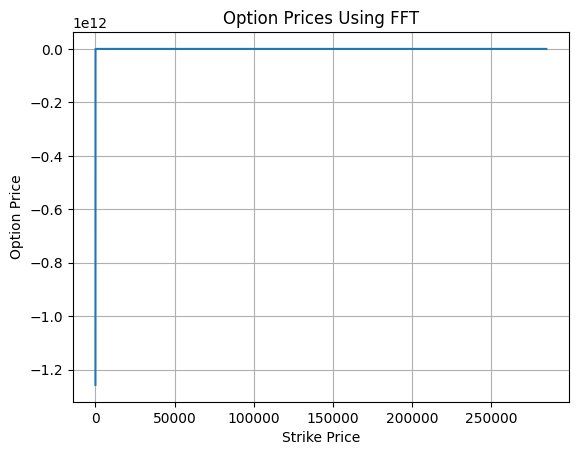

In [4]:
### 5. Testing and Visualization

if __name__ == "__main__":
    # Parameters
    S0, r, sigma, T, K = 100, 0.05, 0.2, 1, 100
    theta, nu = -0.1, 0.2

    # Monte Carlo Pricing
    mc_price = monte_carlo_price(S0, r, sigma, T, K, n=1000, process="gbm")
    bs_price = black_scholes_price(S0, r, sigma, T, K)

    # FFT Pricing
    strikes, fft_prices = fft_price(S0, r, sigma, T)

    # Display Results
    print(f"Monte Carlo Price: {mc_price:.4f}")
    print(f"Black-Scholes Price: {bs_price:.4f}")

    plt.plot(strikes, fft_prices)
    plt.title("Option Prices Using FFT")
    plt.xlabel("Strike Price")
    plt.ylabel("Option Price")
    plt.grid()
    plt.show()

